In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
import string
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

from graphviz import Source
from IPython.display import SVG
from prettytable import PrettyTable


from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


from nltk.stem.porter import PorterStemmer

import re
import nltk
from nltk.corpus import stopwords


from tqdm import tqdm

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix



In [2]:
con = sqlite3.connect('./final_review_data_set.db')
review_data = pd.read_sql_query("select * from Review",con)

review_data.shape , display(review_data.head()) , review_data.isna().any()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,1,1108425600,"Nice cadence, catchy rhymes",junei saw charming groupof roses beginto droop...
1,1,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,fun way children learn months year learn poems...
2,2,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version",grew reading sendak books watching really rosi...
3,3,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,1,1210809600,A classic,get movie sound track sing along carol king gr...
4,4,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,1,1212278400,Chicken Soup with Rice,entertaining rhyming story cleaver catchy illu...


((393931, 11),
 None,
 index                     False
 Id                        False
 ProductId                 False
 UserId                    False
 ProfileName               False
 HelpfulnessNumerator      False
 HelpfulnessDenominator    False
 Score                     False
 Time                      False
 Summary                   False
 Text                      False
 dtype: bool)

In [3]:
X_data = review_data.drop(['Score'],axis=1)
y_data = review_data['Score']

In [4]:
count_vect = CountVectorizer(min_df=0.01)
X_bow = count_vect.fit_transform(X_data['Text'].values)
X_bow

<393931x632 sparse matrix of type '<class 'numpy.int64'>'
	with 7841554 stored elements in Compressed Sparse Row format>

In [5]:
#applying fit transform on train datasset
tf_idf_vect = TfidfVectorizer(min_df=0.01)
x_tfidf = tf_idf_vect.fit_transform(X_data['Text'].values)

In [6]:
textsplits = [text.split() for text in X_data['Text'].values]
textsplits

[['junei',
  'saw',
  'charming',
  'groupof',
  'roses',
  'beginto',
  'droopi',
  'pepped',
  'upwith',
  'chicken',
  'soup',
  'sprinkle',
  'oncesprinkle',
  'twicesprinkle',
  'chicken',
  'soupwith',
  'ricethis',
  'great',
  'book',
  'teach',
  'children',
  'months',
  'year',
  'repetition',
  'phrases',
  'funny',
  'little',
  'stories',
  'accompanying',
  'pictures',
  'make',
  'ideal',
  'bedtime',
  'read',
  'nearly',
  'good',
  'sendak',
  'books',
  'like',
  'wild',
  'things',
  'pierre',
  'boy',
  'care',
  'still',
  'carries',
  'unique',
  'brand',
  'charm'],
 ['fun',
  'way',
  'children',
  'learn',
  'months',
  'year',
  'learn',
  'poems',
  'throughout',
  'school',
  'year',
  'like',
  'handmotions',
  'invent',
  'poem'],
 ['grew',
  'reading',
  'sendak',
  'books',
  'watching',
  'really',
  'rosie',
  'movie',
  'incorporates',
  'love',
  'son',
  'loves',
  'however',
  'miss',
  'hard',
  'cover',
  'version',
  'paperbacks',
  'seem',
  

In [7]:
w2v_model = Word2Vec(textsplits,min_count=10,vector_size=65)
X_w2v = w2v_model.wv.key_to_index.keys()


In [8]:
w2v_words = list(X_w2v)
list_vectors = []

for text in tqdm(textsplits):
    count_words = 0
    text_vec = np.zeros(65)
    
    for w in text:

        if w in w2v_words:
            count_words += 1
            vec = w2v_model.wv[w]
            text_vec += vec

    if count_words != 0:
        text_vec /= count_words

    list_vectors.append(text_vec)

print(len(list_vectors))
print(len(list_vectors[0]))



100%|██████████| 393931/393931 [03:24<00:00, 1925.61it/s]

393931
100


In [9]:
X_w2v = np.array(list_vectors)
X_w2v

array([[-0.30841731, -0.01775394,  0.23423721, ..., -0.05598884,
        -0.56647505, -0.50002973],
       [-0.19517074, -0.89261888,  0.18541079, ...,  0.59331814,
         0.13379285, -2.144985  ],
       [ 0.19443596, -0.83771257, -0.1024512 , ..., -0.08101669,
        -0.22186353, -0.94063843],
       ...,
       [ 0.20346596, -0.14616545,  0.93962969, ..., -0.5832643 ,
         0.11250039,  0.61352408],
       [ 0.26116515, -0.57838278,  0.24446496, ..., -0.45541428,
        -0.00989243, -0.8292767 ],
       [-0.19860512, -0.58833496, -0.15176068, ...,  0.56016966,
        -0.09989307, -0.9261952 ]])

In [11]:
# tfidf - word2vec
tf_idf_model = TfidfVectorizer()
tf_idf_matrix = tf_idf_model.fit_transform(X_data['Text'].values)
mapped_data = dict(zip(tf_idf_model.get_feature_names_out(), list(tf_idf_model.idf_)))
mapped_data

{'aa': 9.566445471016106,
 'aaa': 10.482736202890262,
 'aaaa': 11.581348491558371,
 'aaaaa': 11.486038311754047,
 'aaaaaa': 12.785321295884307,
 'aaaaaaaaaa': 13.190786403992472,
 'aaaaaaaaaaa': 13.190786403992472,
 'aaaaaaaaaaaa': 13.190786403992472,
 'aaaaaaaaaaaaa': 13.190786403992472,
 'aaaaaaaaaaaaaa': 13.190786403992472,
 'aaaaaaaaaaaaaaa': 13.190786403992472,
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa': 13.190786403992472,
 'aaaaaaaaaaaaaaaaaaaargh': 13.190786403992472,
 'aaaaaaaaaaaaaaaaacccccccckkkkkk': 13.190786403992472,
 'aaaaaaaaagghh': 13.190786403992472,
 'aaaaaaah': 13.190786403992472,
 'aaaaaaahhhhhh': 13.190786403992472,
 'aaaaaaarrrrrggghhh': 13.190786403992472,
 'aaaaaah': 12.785321295884307,
 'aaaaaahhh': 13.190786403992472,
 'aaaaaahhhh': 13.190786403992472,
 'aaaaaahhhhh': 13.190786403992472,
 'aaaaaahhhhhyaaaaaa': 13.190786403992472,
 'aaaaaand': 13.190786403992472,
 'aaaaaawwwwwwwwww': 13.190786403992472,
 'aaaaah': 12.785321295884307,
 'aaaaahhhhhhhhhhhhhh

In [12]:
# TF-IDF weighted Word2Vec

tfidf_text_vectors = []

for text in tqdm(textsplits):
    weight_sum = 0 
    text_vec = np.zeros(65)

    for w in text: 
        if w in w2v_words and len(w) != 1:
            vec = w2v_model.wv[w]
            data = mapped_data[w]*(text.count(w)/len(text))
            text_vec += (vec * data)
            weight_sum += data

    if weight_sum != 0:
        text_vec /= weight_sum
        
    tfidf_text_vectors.append(text_vec)


100%|██████████| 393931/393931 [04:02<00:00, 1627.14it/s]


In [13]:
X_tfw2v = np.array(tfidf_text_vectors)


In [14]:
# decision tree

In [15]:
# split the dataset
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(
    X_bow, y_data, test_size=0.1, random_state=234)

In [16]:
# initializing DecisionTreeClassifier model
decision_tree_model = DecisionTreeClassifier()

max_depth = [1, 10, 30, 50, 100, 500]
min_samples_split  = [5, 10, 30, 50, 100, 500]
param_grid = {'max_depth':[1, 10, 30, 50, 100, 500],
              'min_samples_split':[5, 10, 30, 50, 100, 500]}

In [17]:

# using GridSearchCV 
grid_search = GridSearchCV(decision_tree_model,param_grid,scoring='roc_auc',cv=5,n_jobs=-1,return_train_score=True)

grid_search.fit(X_train_bow,y_train_bow)
print("Best Max Depth Value:",grid_search.best_params_['max_depth'])
print("Best Min Sample Split Value:",grid_search.best_params_['min_samples_split'])
print("Best ROC AUC Score: %.5f"%(grid_search.best_score_))

/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [18]:
# determining optimal depth and sample split values
optimal_depth = grid_search.best_params_['max_depth']
optimal_sample_split = grid_search.best_params_['min_samples_split']

#training the model using the optimal hyperparameters
decisiontree_model_final = DecisionTreeClassifier(max_depth=optimal_depth, min_samples_split=optimal_sample_split)
decisiontree_model_final.fit(X_train_bow,y_train_bow)

#predicting the class label using test data 
y_pred = decisiontree_model_final.predict_proba(X_test_bow)[:,1]

#determining the Test roc_auc_score for optimal hyperparameters
auc_score = roc_auc_score(y_test_bow, y_pred)
print('\n**** Test roc_auc_score is %f ****' % (auc_score))


**** Test roc_auc_score is 0.773092 ****


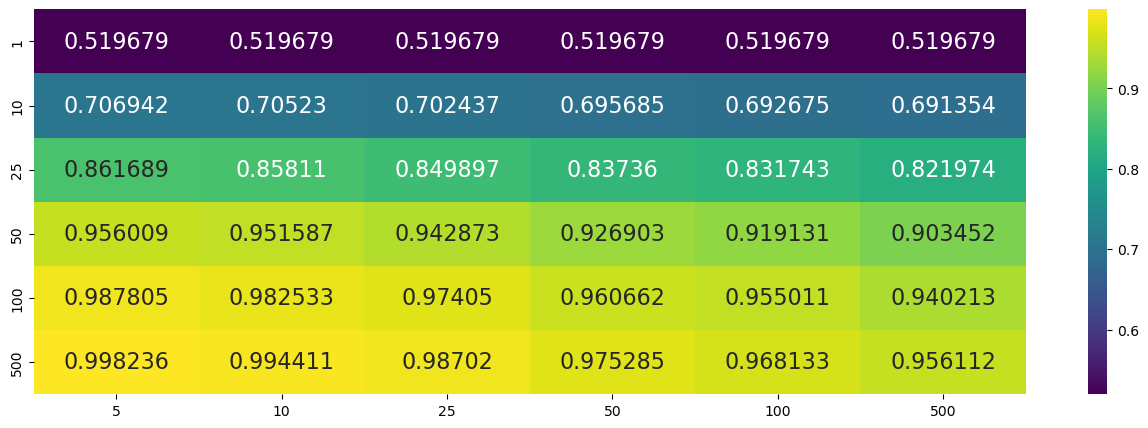

In [19]:
# train data
A=np.array(grid_search.cv_results_['mean_train_score'])
B = np.reshape(A, (6,6))
df = pd.DataFrame(B, index=max_depth, columns=min_samples_split)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

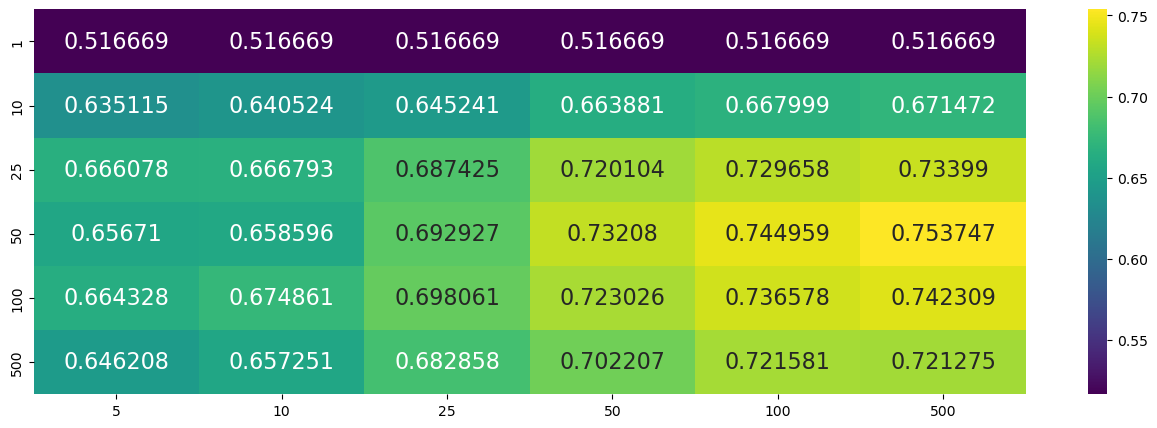

In [20]:
# test data
A=np.array(grid_search.cv_results_['mean_test_score'])
B = np.reshape(A, (6,6))
df = pd.DataFrame(B, index=max_depth, columns=min_samples_split)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

[[ 696  716]
 [ 329 8293]]


<Axes: >

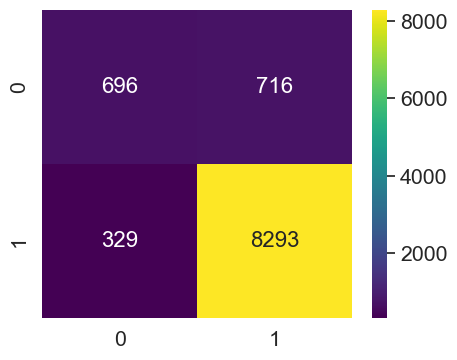

In [21]:
# plotting confusion matrix as heatmap
y_predict = decisiontree_model_final.predict(X_train_bow)
cm = confusion_matrix(y_train_bow, y_predict)
print(cm)
plt.figure(figsize = (5,4))
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

[[ 50 104]
 [ 52 909]]


<Axes: >

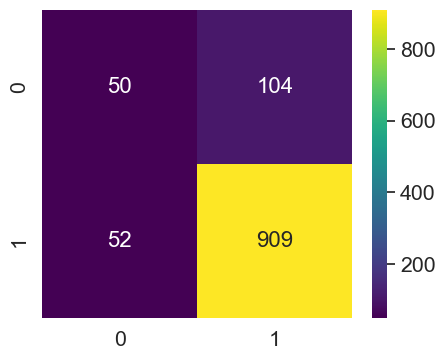

In [22]:
# plotting confusion matrix as heatmap
y_predict = decisiontree_model_final.predict(X_test_bow)
cm = confusion_matrix(y_test_bow, y_predict)
print(cm)
plt.figure(figsize = (5,4))
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

In [23]:
#roc

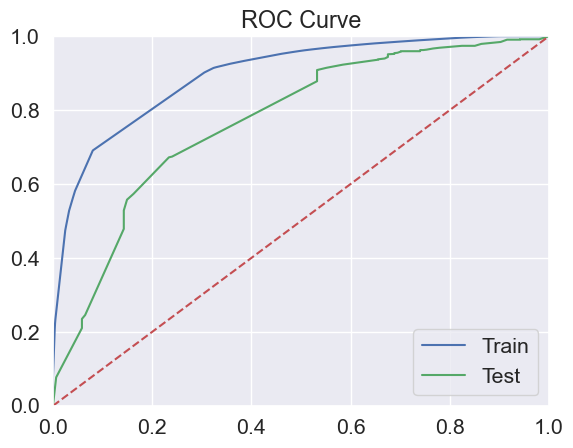

In [24]:
# Plotting roc curve on Train Data
pred_train = decisiontree_model_final.predict_proba(X_train_bow)[:,1]
fpr, tpr, threshold = roc_curve(y_train_bow, pred_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
pred_test = decisiontree_model_final.predict_proba(X_test_bow)[:,1]
fpr, tpr, threshold = roc_curve(y_test_bow, pred_test)
plt.plot(fpr, tpr, 'g', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

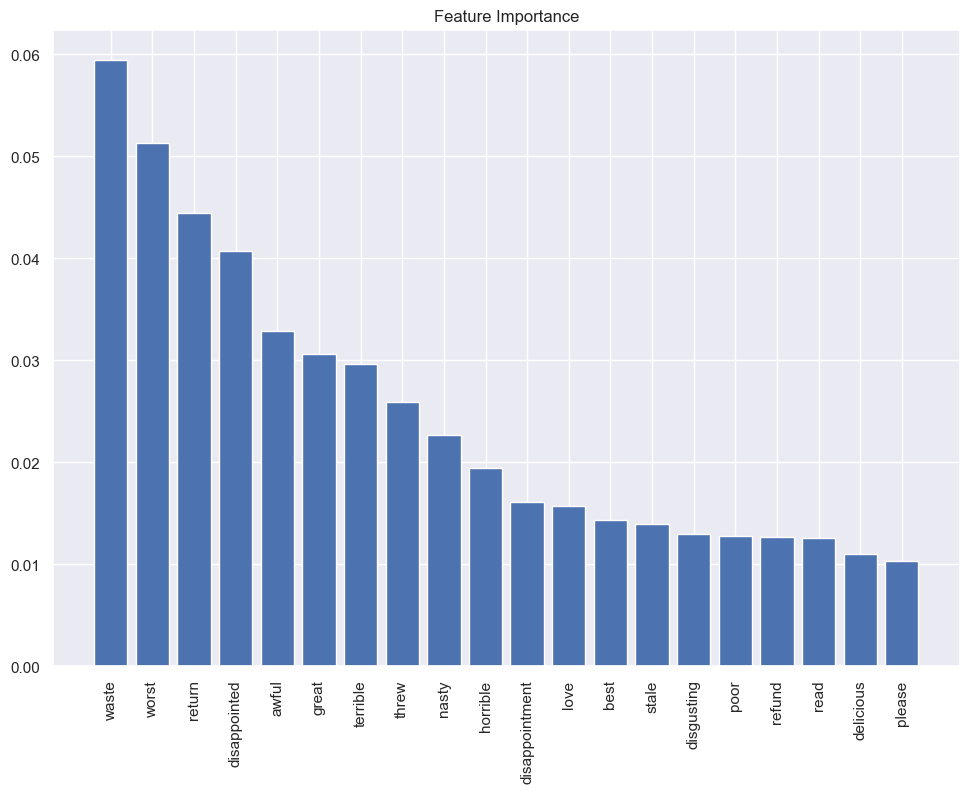

In [25]:

# Calculate feature importances from decision trees
importances = decisiontree_model_final.feature_importances_
# Sort feature importances in descending order and get their indices
indices = np.argsort(importances)[::-1][:20]
# Get the feature names from the vectorizer
names = count_vect.get_feature_names_out()

sns.set(rc={'figure.figsize':(11.7,8.27)})
# Create plot
plt.figure()
# Create plot title
plt.title("Feature Importance")
# Add bars
plt.bar(range(20), importances[indices])
# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(20), names[indices], rotation=90)
# Show plot
plt.show()

In [26]:
graph = Source(tree.export_graphviz(decisiontree_model_final, out_file=None, class_names=['negative','positive'],
                                     filled=True, rounded=True, feature_names=names))
SVG(graph.pipe(format='svg'))
graph.view()

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [27]:
# split the dataset
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    x_tfidf, y_data, test_size=0.1, random_state=234)

In [28]:
# initializing DecisionTreeClassifier model
decision_tree_model = DecisionTreeClassifier()

# hyperparameter values we need to try on classifier
max_depth = [1, 10, 25, 50, 100, 500]
min_samples_split  = [5, 10, 25, 50, 100, 500]
param_grid = {'max_depth':[1, 10, 25, 50, 100, 500],
              'min_samples_split':[5, 10, 25, 50, 100, 500]}

# using GridSearchCV to find the optimal value of hyperparameters
# using roc_auc as the scoring parameter & applying 5 fold CV
grid_search = GridSearchCV(decision_tree_model,param_grid,scoring='roc_auc',cv=5,n_jobs=-1,return_train_score=True)

grid_search.fit(X_train_tfidf,y_train_tfidf)
print("Best Max Depth Value:",grid_search.best_params_['max_depth'])
print("Best Min Sample Split Value:",grid_search.best_params_['min_samples_split'])
print("Best ROC AUC Score: %.5f"%(grid_search.best_score_))

Best Max Depth Value: 100
Best Min Sample Split Value: 500
Best ROC AUC Score: 0.72610


In [29]:
# determining optimal depth and sample split values
optimal_depth = grid_search.best_params_['max_depth']
optimal_sample_split = grid_search.best_params_['min_samples_split']

#training the model using the optimal hyperparameters
decisiontree_model_final = DecisionTreeClassifier(max_depth=optimal_depth, min_samples_split=optimal_sample_split)
decisiontree_model_final.fit(X_train_tfidf,y_train_tfidf)

#predicting the class label using test data 
y_pred = decisiontree_model_final.predict_proba(X_test_tfidf)[:,1]

#determining the Test roc_auc_score for optimal hyperparameters
auc_score = roc_auc_score(y_test_tfidf, y_pred)
print('\n**** Test roc_auc_score is %f ****' % (auc_score))


**** Test roc_auc_score is 0.771903 ****


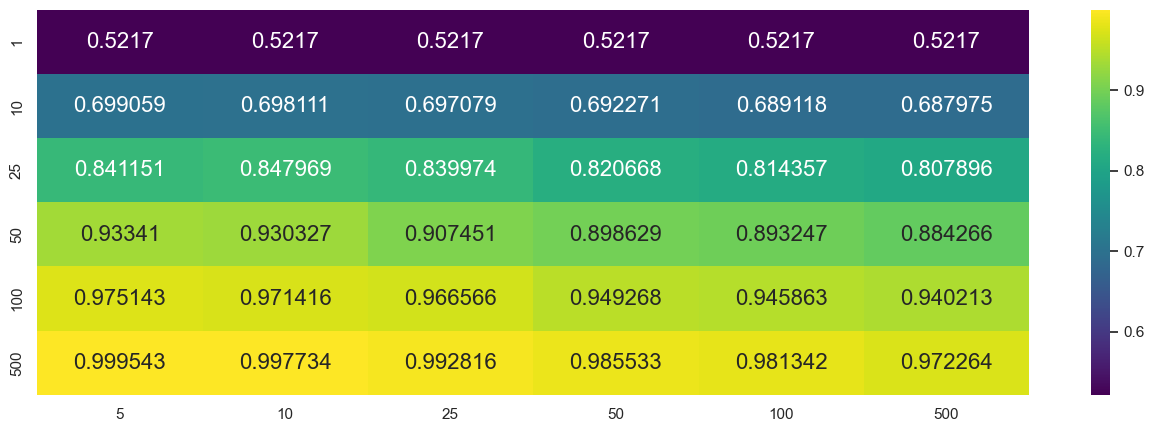

In [30]:
A=np.array(grid_search.cv_results_['mean_train_score'])
B = np.reshape(A, (6,6))
df = pd.DataFrame(B, index=max_depth, columns=min_samples_split)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

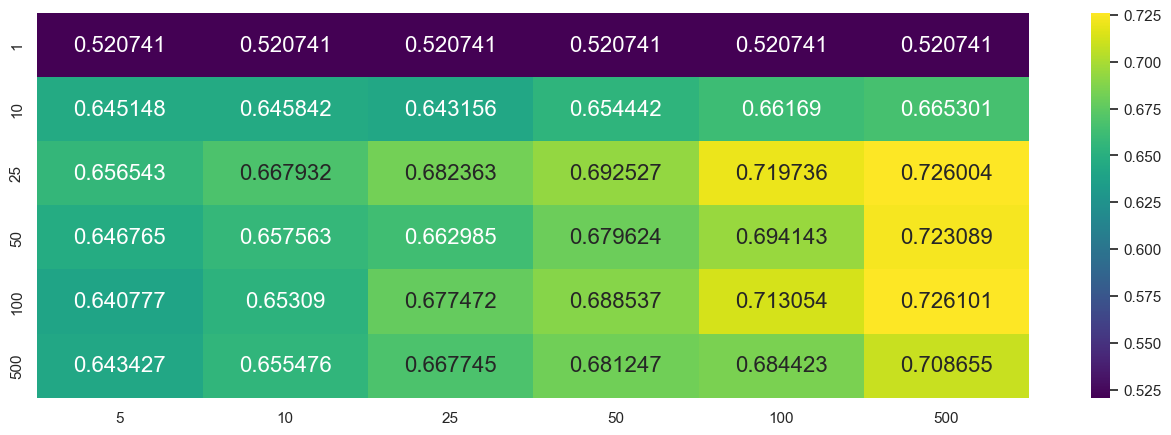

In [31]:
A=np.array(grid_search.cv_results_['mean_test_score'])
B = np.reshape(A, (6,6))
df = pd.DataFrame(B, index=max_depth, columns=min_samples_split)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

[[ 784  628]
 [ 260 8362]]


<Axes: >

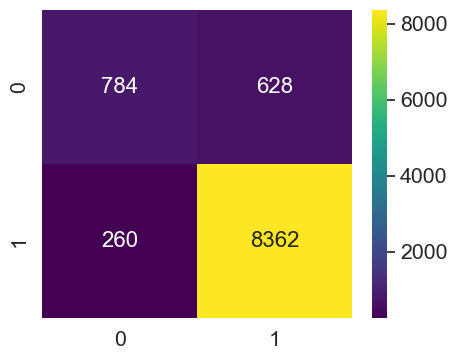

In [34]:
# plotting confusion matrix as heatmap
y_predict = decisiontree_model_final.predict(X_train_tfidf)
cm = confusion_matrix(y_train_tfidf, y_predict)
print(cm)
plt.figure(figsize = (5,4))
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

[[ 50 104]
 [ 58 903]]


<Axes: >

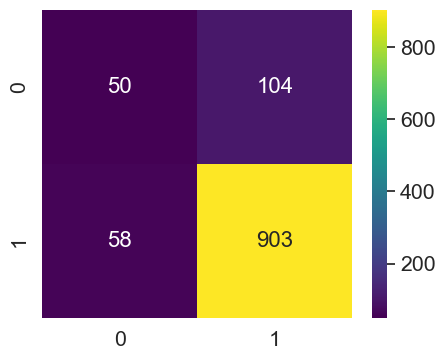

In [33]:
# plotting confusion matrix as heatmap
y_predict = decisiontree_model_final.predict(X_test_tfidf)
cm = confusion_matrix(y_test_tfidf, y_predict)
print(cm)
plt.figure(figsize = (5,4))
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

In [35]:
# ROC curve

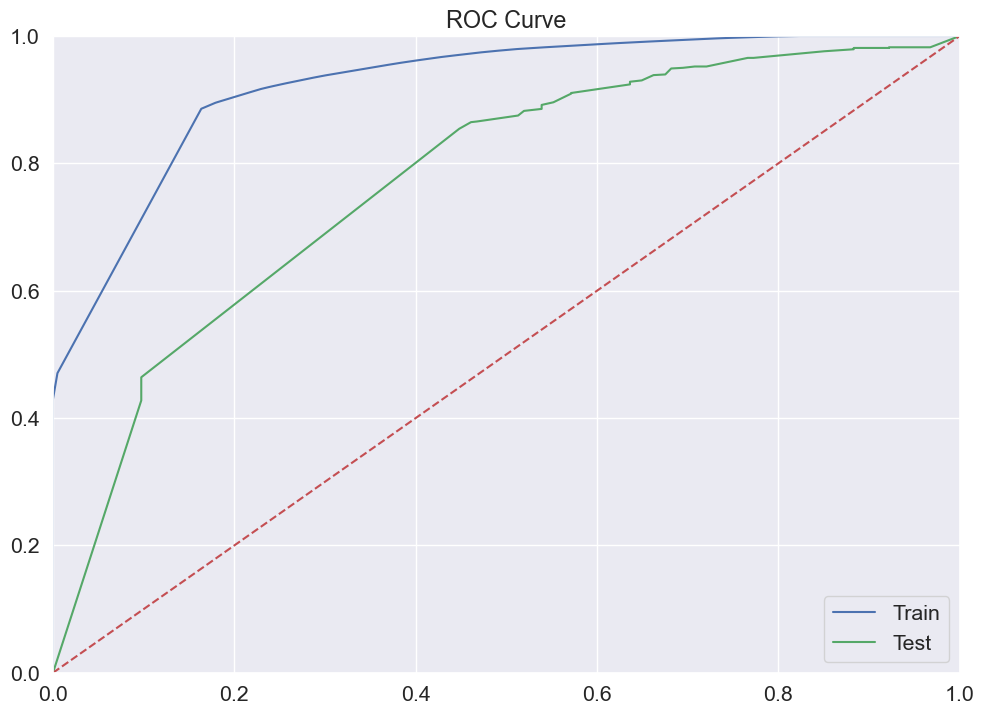

In [36]:
# Plotting roc curve on Train Data
pred_train = decisiontree_model_final.predict_proba(X_train_tfidf)[:,1]
fpr, tpr, threshold = roc_curve(y_train_tfidf, pred_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
pred_test = decisiontree_model_final.predict_proba(X_test_tfidf)[:,1]
fpr, tpr, threshold = roc_curve(y_test_tfidf, pred_test)
plt.plot(fpr, tpr, 'g', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

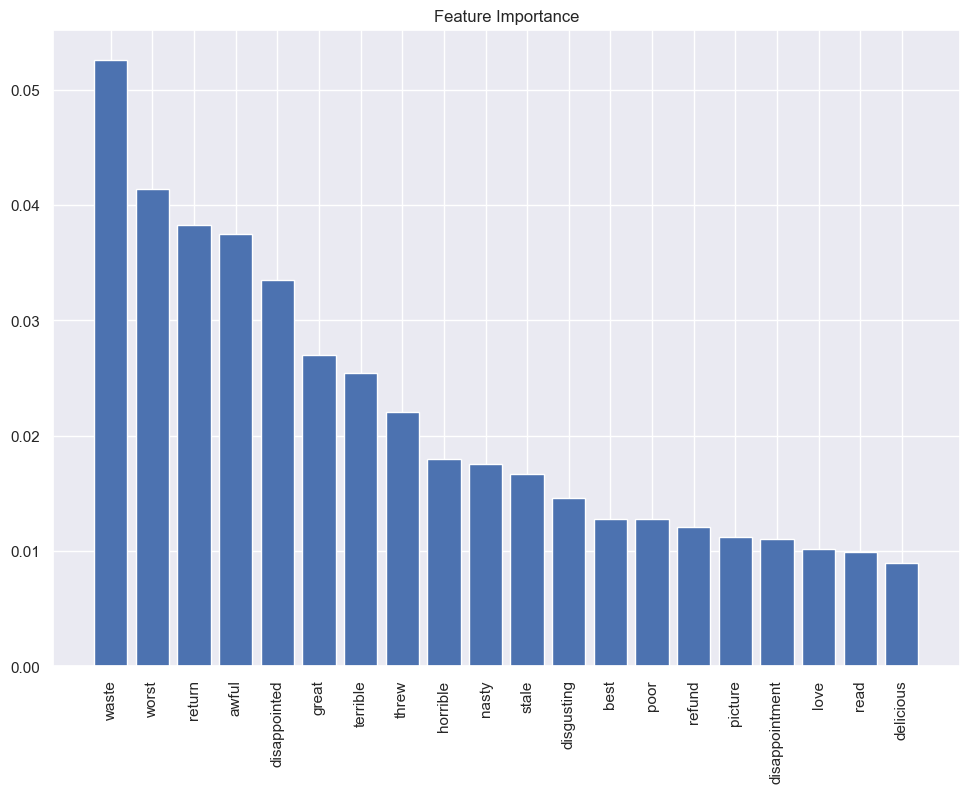

In [38]:
# Calculate feature importances from decision trees
importances = decisiontree_model_final.feature_importances_

# Sort feature importances in descending order and get their indices
indices = np.argsort(importances)[::-1][:20]

# Get the feature names from the vectorizer
names = tf_idf_vect.get_feature_names_out()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(20), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(20), names[indices], rotation=90)

# Show plot
plt.show()

In [39]:
# Avg W2V

In [42]:
# split the dataset
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_w2v, y_data, test_size=0.1, random_state=234)

In [43]:
# initializing DecisionTreeClassifier model
decision_tree_model = DecisionTreeClassifier()

# hyperparameter values we need to try on classifier
max_depth = [1, 10, 25, 50, 100, 500]
min_samples_split  = [10, 25, 50, 100, 500, 1000]
param_grid = {'max_depth':[1, 10, 25, 50, 100, 500],
              'min_samples_split':[10, 25, 50, 100, 500, 1000]}

# using GridSearchCV to find the optimal value of hyperparameters
# using roc_auc as the scoring parameter & applying 5 fold CV
grid_search = GridSearchCV(decision_tree_model,param_grid,scoring='roc_auc',cv=5,n_jobs=-1,return_train_score=True)

grid_search.fit(X_train_w2v,y_train_w2v)
print("Best Max Depth Value:",grid_search.best_params_['max_depth'])
print("Best Min Sample Split Value:",grid_search.best_params_['min_samples_split'])
print("Best ROC AUC Score: %.5f"%(grid_search.best_score_))

Best Max Depth Value: 25
Best Min Sample Split Value: 500
Best ROC AUC Score: 0.68445


In [44]:
# determining optimal depth and sample split values
optimal_depth = grid_search.best_params_['max_depth']
optimal_sample_split = grid_search.best_params_['min_samples_split']

#training the model using the optimal hyperparameters
decisiontree_model_final = DecisionTreeClassifier(max_depth=optimal_depth, min_samples_split=optimal_sample_split)
decisiontree_model_final.fit(X_train_w2v,y_train_w2v)

#predicting the class label using test data 
y_pred = decisiontree_model_final.predict_proba(X_test_w2v)[:,1]

#determining the Test roc_auc_score for optimal hyperparameters
auc_score = roc_auc_score(y_test_w2v, y_pred)
print('\n**** Test roc_auc_score is %f ****' % (auc_score))


**** Test roc_auc_score is 0.707684 ****


In [45]:
# seaborn heatmap on Train Data

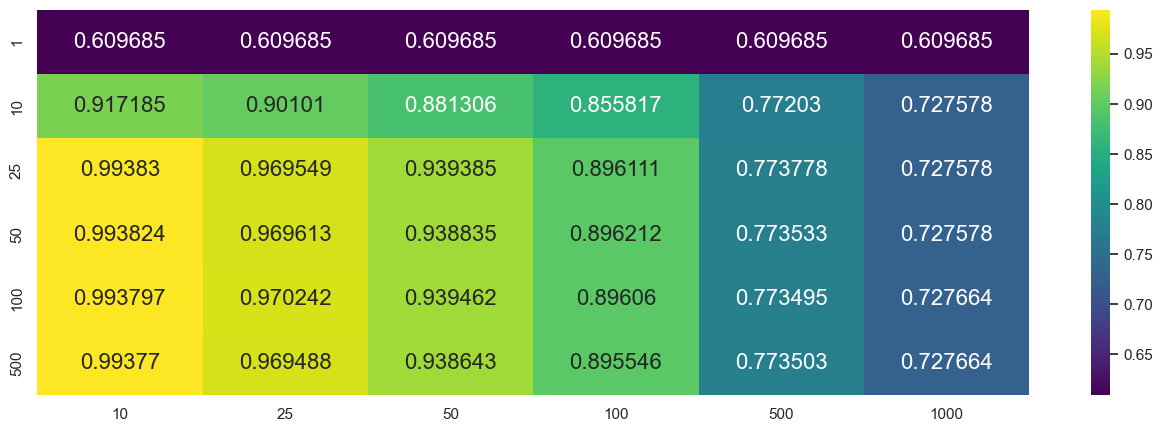

In [46]:
A=np.array(grid_search.cv_results_['mean_train_score'])
B = np.reshape(A, (6,6))
df = pd.DataFrame(B, index=max_depth, columns=min_samples_split)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

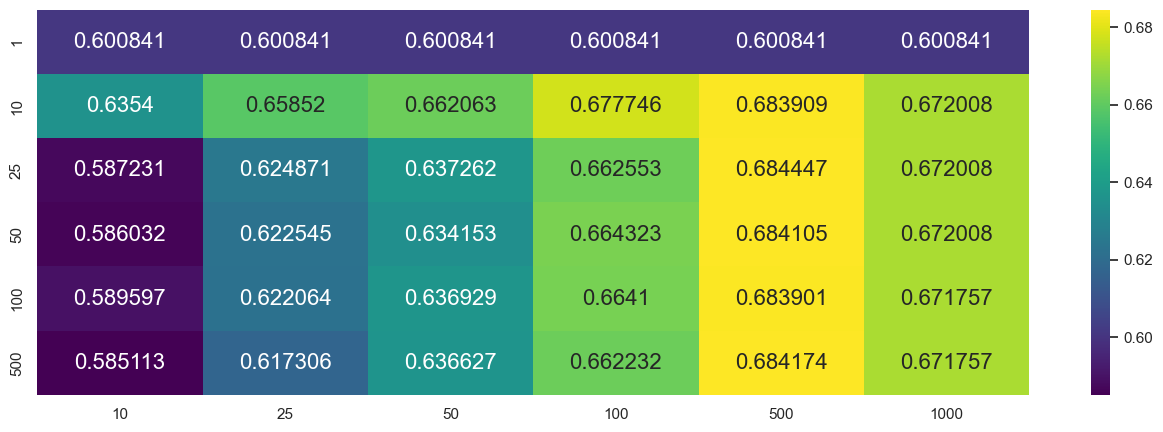

In [47]:
A=np.array(grid_search.cv_results_['mean_test_score'])
B = np.reshape(A, (6,6))
df = pd.DataFrame(B, index=max_depth, columns=min_samples_split)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

[[  21 1391]
 [   9 8613]]


<Axes: >

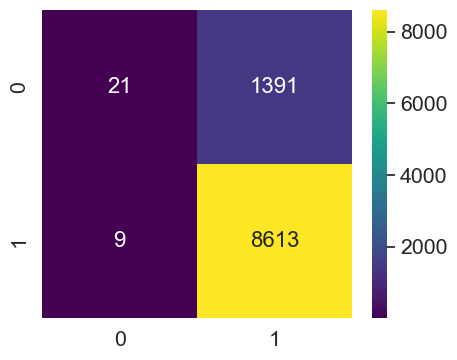

In [49]:
# plotting confusion matrix as heatmap
y_predict = decisiontree_model_final.predict(X_train_w2v)
cm = confusion_matrix(y_train_w2v, y_predict)
print(cm)
plt.figure(figsize = (5,4))
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

[[  0 154]
 [  1 960]]


<Axes: >

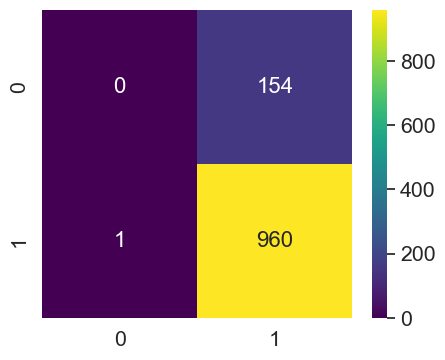

In [48]:
# plotting confusion matrix as heatmap
y_predict = decisiontree_model_final.predict(X_test_w2v)
cm = confusion_matrix(y_test_w2v, y_predict)
print(cm)
plt.figure(figsize = (5,4))
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

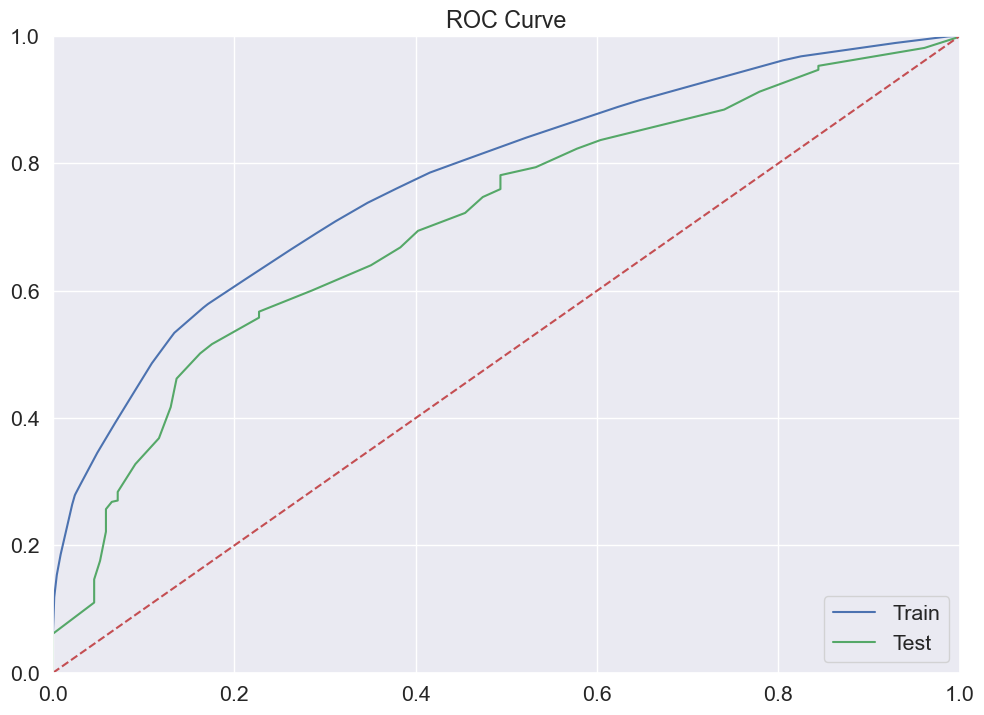

In [50]:
# Plotting roc curve on Train Data
pred_train = decisiontree_model_final.predict_proba(X_train_w2v)[:,1]
fpr, tpr, threshold = roc_curve(y_train_w2v, pred_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
pred_test = decisiontree_model_final.predict_proba(X_test_w2v)[:,1]
fpr, tpr, threshold = roc_curve(y_test_w2v, pred_test)
plt.plot(fpr, tpr, 'g', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [51]:
# tfidf w2v

In [53]:
# split the dataset
X_train_tfw2v, X_test_tfw2v, y_train_tfw2v, y_test_tfw2v = train_test_split(
    X_tfw2v, y_data, test_size=0.1, random_state=234)

In [54]:
# initializing DecisionTreeClassifier model
decision_tree_model = DecisionTreeClassifier()

# hyperparameter values we need to try on classifier
max_depth = [1, 10, 25, 50, 100, 500]
min_samples_split  = [10, 25, 50, 100, 500, 1000]
param_grid = {'max_depth':[1, 10, 25, 50, 100, 500],
              'min_samples_split':[10, 25, 50, 100, 500, 1000]}

# using GridSearchCV to find the optimal value of hyperparameters
# using roc_auc as the scoring parameter & applying 5 fold CV
grid_search = GridSearchCV(decision_tree_model,param_grid,scoring='roc_auc',cv=5,n_jobs=-1,return_train_score=True)

grid_search.fit(X_train_tfw2v,y_train_tfw2v)
print("Best Max Depth Value:",grid_search.best_params_['max_depth'])
print("Best Min Sample Split Value:",grid_search.best_params_['min_samples_split'])
print("Best ROC AUC Score: %.5f"%(grid_search.best_score_))

Best Max Depth Value: 25
Best Min Sample Split Value: 500
Best ROC AUC Score: 0.65730


In [55]:
# determining optimal depth and sample split values
optimal_depth = grid_search.best_params_['max_depth']
optimal_sample_split = grid_search.best_params_['min_samples_split']

#training the model using the optimal hyperparameters
decisiontree_model_final = DecisionTreeClassifier(max_depth=optimal_depth, min_samples_split=optimal_sample_split)
decisiontree_model_final.fit(X_train_tfw2v,y_train_tfw2v)

#predicting the class label using test data 
y_pred = decisiontree_model_final.predict_proba(X_test_tfw2v)[:,1]

#determining the Test roc_auc_score for optimal hyperparameters
auc_score = roc_auc_score(y_test_tfw2v, y_pred)
print('\n**** Test roc_auc_score is %f ****' % (auc_score))


**** Test roc_auc_score is 0.709711 ****


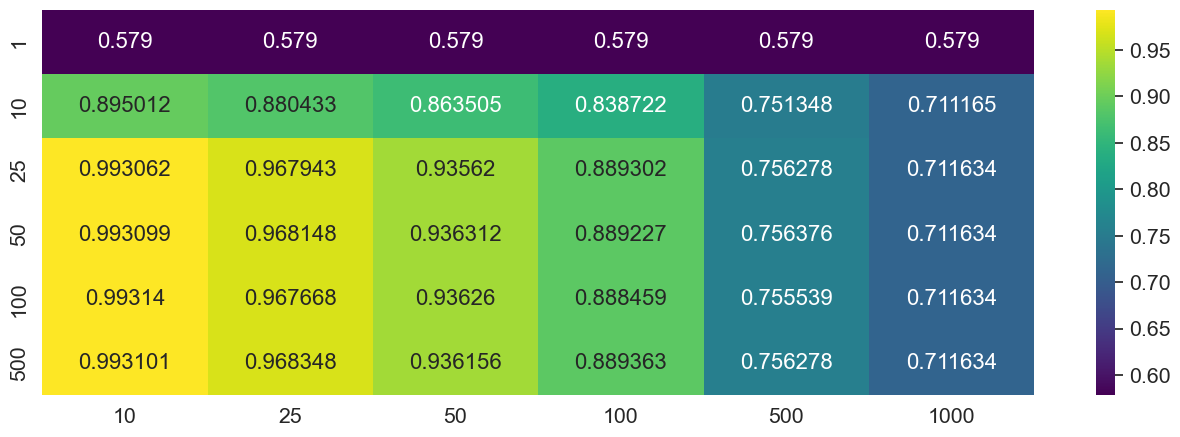

In [56]:
A=np.array(grid_search.cv_results_['mean_train_score'])
B = np.reshape(A, (6,6))
df = pd.DataFrame(B, index=max_depth, columns=min_samples_split)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

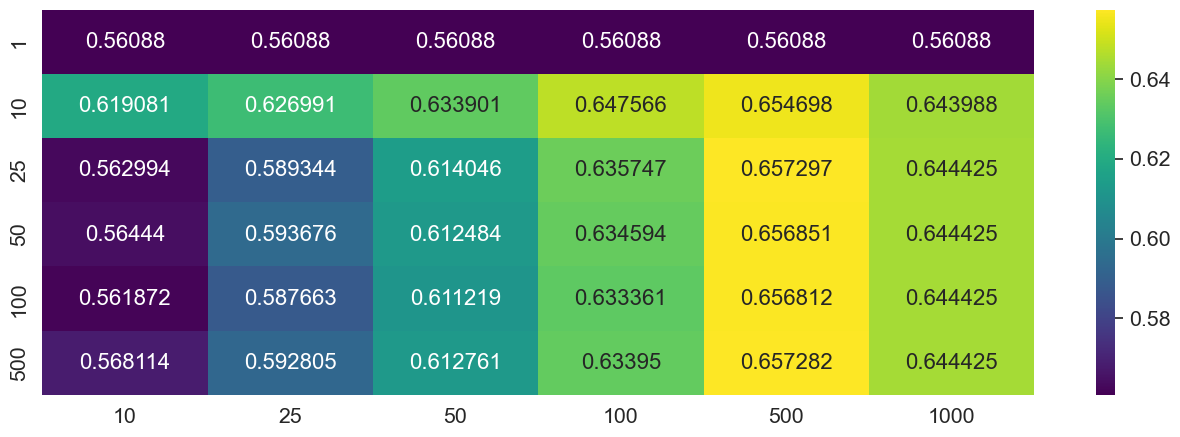

In [57]:
A=np.array(grid_search.cv_results_['mean_test_score'])
B = np.reshape(A, (6,6))
df = pd.DataFrame(B, index=max_depth, columns=min_samples_split)
plt.figure(figsize = (16,5))
sns.heatmap(df, annot=True, annot_kws={"size": 16}, fmt="g", cmap='viridis')
plt.show()

[[  2 152]
 [ 10 951]]


<Axes: >

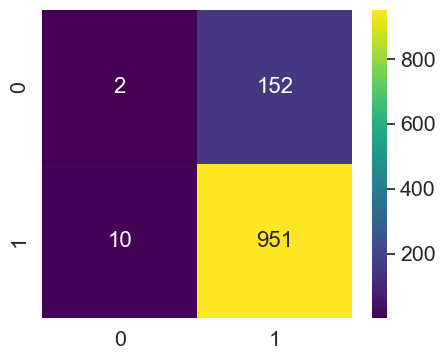

In [58]:
# plotting confusion matrix as heatmap
y_predict = decisiontree_model_final.predict(X_test_tfw2v)
cm = confusion_matrix(y_test_tfw2v, y_predict)
print(cm)
plt.figure(figsize = (5,4))
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

[[  55 1357]
 [  30 8592]]


<Axes: >

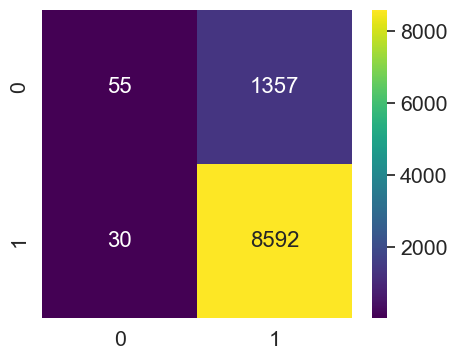

In [59]:
# plotting confusion matrix as heatmap
y_predict = decisiontree_model_final.predict(X_train_tfw2v)
cm = confusion_matrix(y_train_tfw2v, y_predict)
print(cm)
plt.figure(figsize = (5,4))
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',cmap='viridis')

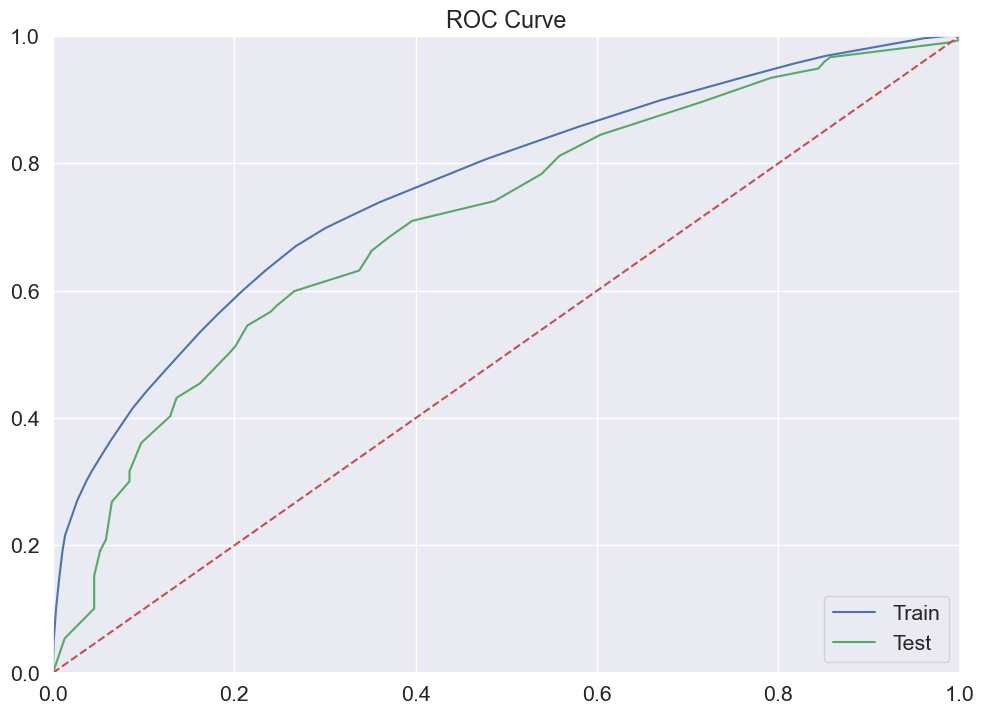

In [60]:
# Plotting roc curve on Train Data
pred_train = decisiontree_model_final.predict_proba(X_train_tfw2v)[:,1]
fpr, tpr, threshold = roc_curve(y_train_tfw2v, pred_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
pred_test = decisiontree_model_final.predict_proba(X_test_tfw2v)[:,1]
fpr, tpr, threshold = roc_curve(y_test_tfw2v, pred_test)
plt.plot(fpr, tpr, 'g', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [61]:
# conclusion